In [1]:
# 📦 Import necessary libraries
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns

# 📈 Optional: visualization config
sns.set(style="whitegrid")

In [2]:
# === 📥 LOAD Final Preprocessed Data ===
df = pd.read_csv("C:/Users/mloai/Event-Aware Sales Forecasting with Time Series Models/sales_with_features.csv")

In [3]:
# Ensure CAL_DATE is datetime
df['CAL_DATE'] = pd.to_datetime(df['CAL_DATE'])

In [4]:
# One-hot encode Category_Channel (keep all columns)
dummies = pd.get_dummies(df['Category_Channel'], prefix='Category_Channel', dtype='uint8')
df = pd.concat([df, dummies], axis=1)

In [5]:
# Sort before feature engineering
df = df.sort_values(by=['Category_Channel', 'CAL_DATE']).reset_index(drop=True)

# === 🛠️ Create lag/rolling features by Category_Channel group ===
processed_groups = []

for cat_code, group in df.groupby('Category_Channel'):
    group = group.sort_values(by='CAL_DATE')

    group['sales_lag_4'] = group['LOG_SALES'].shift(4)
    group['sales_lag_8'] = group['LOG_SALES'].shift(8)
    group['sales_lag_12'] = group['LOG_SALES'].shift(12)
    
    group['sales_roll_mean_4'] = group['LOG_SALES'].shift(1).rolling(4, min_periods=1).mean()
    group['sales_roll_mean_8'] = group['LOG_SALES'].shift(1).rolling(8, min_periods=1).mean()
    group['sales_roll_mean_12'] = group['LOG_SALES'].shift(1).rolling(12, min_periods=1).mean()
    
    group['sales_roll_std_4']  = group['LOG_SALES'].shift(1).rolling(4, min_periods=1).std()
    group['sales_roll_std_8']  = group['LOG_SALES'].shift(1).rolling(8, min_periods=1).std()
    group['sales_roll_std_12']  = group['LOG_SALES'].shift(1).rolling(12, min_periods=1).std()
    
    processed_groups.append(group)

df_final = pd.concat(processed_groups).reset_index(drop=True)

# Drop rows with NaNs from lag/rolling
df_final = df_final.dropna(subset=[
    'sales_lag_4', 'sales_lag_8','sales_lag_12',
    'sales_roll_mean_4', 'sales_roll_mean_8','sales_roll_mean_12',
    'sales_roll_std_4', 'sales_roll_std_8','sales_roll_std_12'
])

📅 Train Range: 2022-01-13 00:00:00 to 2024-12-31 00:00:00
📅 Test Range:  2025-01-01 00:00:00 to 2025-05-25 00:00:00
✅ Train Size: 35752 rows
✅ Test Size:  5048 rows


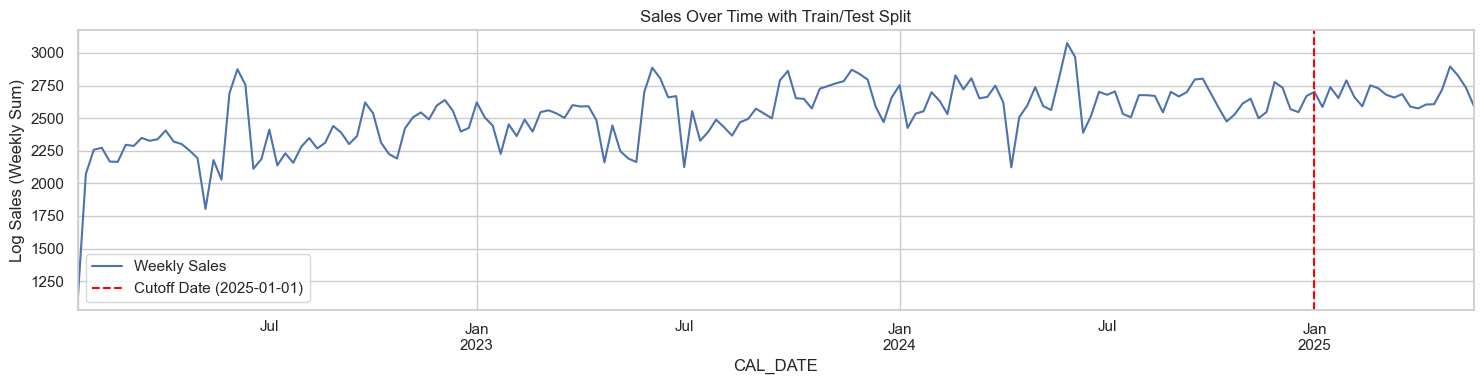

In [6]:
# === 🔁 Train/Test Split ===
train = df_final[df_final['CAL_DATE'] < '2025-01-01']
test = df_final[(df_final['CAL_DATE'] >= '2025-01-01') & (df_final['CAL_DATE'] <= '2025-05-31')]

# Columns to drop before modeling
drop_cols = ['CAL_DATE', 'HIJRI_DATE', 'Main Event', 'event_category', 'Category_Channel']

X_train = train.drop(columns=drop_cols + ['LOG_SALES'])
y_train = train['LOG_SALES']

X_test = test.drop(columns=drop_cols + ['LOG_SALES'])
y_test = test['LOG_SALES']

# === 📊 Print Summary ===
print("📅 Train Range:", train['CAL_DATE'].min(), "to", train['CAL_DATE'].max())
print("📅 Test Range: ", test['CAL_DATE'].min(), "to", test['CAL_DATE'].max())
print("✅ Train Size:", len(train), "rows")
print("✅ Test Size: ", len(test), "rows")

# === 📈 Visualize Split ===
cutoff_date = pd.to_datetime("2025-01-01")
df_final.set_index('CAL_DATE')['LOG_SALES'].resample('W').sum().plot(figsize=(15, 4), label='Weekly Sales')
plt.axvline(cutoff_date, color='red', linestyle='--', label='Cutoff Date (2025-01-01)')
plt.title("Sales Over Time with Train/Test Split")
plt.ylabel("Log Sales (Weekly Sum)")
plt.legend()
plt.tight_layout()
plt.show()

In [7]:
df_final.head()

CAL_DATE  HIJRI_DATE Main Event      Category_Channel  LOG_SALES  \
12 2023-09-24  1445-03-09         Nd  100_Brick and Mortar   6.944984   
13 2024-02-22  1445-08-12    Regular  100_Brick and Mortar   7.159144   
14 2024-02-24  1445-08-14    Regular  100_Brick and Mortar   6.931179   
15 2024-09-20  1446-03-17         Nd  100_Brick and Mortar   7.035383   
16 2024-09-23  1446-03-20         Nd  100_Brick and Mortar   7.116630   

    Is_Ramadan  Is_Eid_Fitr  Is_Eid_Adha  Hijri_Month  Day  ...  \
12           0            0            0            3   24  ...   
13           0            0            0            8   22  ...   
14           0            0            0            8   24  ...   
15           0            0            0            3   20  ...   
16           0            0            0            3   23  ...   

    Category_Channel_7_Noon  sales_lag_4  sales_lag_8  sales_lag_12  \
12                        0     7.093953     7.121075      7.189703   
13                        0     6.967721     6.999349      7.662242   
14                        0     7.239129     7.596031      7.061034   
15                        0     7.414525     7.533592      7.313980   
16                        0     6.944984     7.093953      7.121075   

    sales_roll_mean_4  sales_roll_mean_8  sales_roll_mean_12  \
12           7.178832           7.245672            7.266028   
13           7.141589           7.223660            7.245634   
14           7.189445           7.243635            7.203710   
15           7.112458           7.160528            7.192888   
16           7.017672           7.098252            7.169672   

    sales_roll_std_4  sales_roll_std_8  sales_roll_std_12  
12          0.192318          0.242215           0.237626  
13          0.225752          0.262322           0.254662  
14          0.194772          0.248523           0.218716  
15          0.226814          0.223779           0.229370  
16          0.105028          0.167331           0.230098  

[5 rows x 115 columns]

In [8]:
df.head()

CAL_DATE  HIJRI_DATE    Main Event      Category_Channel  LOG_SALES  \
0 2022-02-21  1443-07-20  Founding Day  100_Brick and Mortar   7.189703   
1 2022-02-22  1443-07-21  Founding Day  100_Brick and Mortar   7.662242   
2 2022-09-21  1444-02-25            Nd  100_Brick and Mortar   7.061034   
3 2022-09-22  1444-02-26            Nd  100_Brick and Mortar   7.313980   
4 2022-09-23  1444-02-27            Nd  100_Brick and Mortar   7.121075   

   Is_Ramadan  Is_Eid_Fitr  Is_Eid_Adha  Hijri_Month  Day  ...  \
0           0            0            0            7   21  ...   
1           0            0            0            7   22  ...   
2           0            0            0            2   21  ...   
3           0            0            0            2   22  ...   
4           0            0            0            2   23  ...   

   Category_Channel_66_Brick and Mortar  Category_Channel_66_E-Commerce  \
0                                     0                               0   
1                                     0                               0   
2                                     0                               0   
3                                     0                               0   
4                                     0                               0   

   Category_Channel_6_B2B  Category_Channel_6_Brick and Mortar  \
0                       0                                    0   
1                       0                                    0   
2                       0                                    0   
3                       0                                    0   
4                       0                                    0   

   Category_Channel_6_E-Commerce  Category_Channel_6_Noon  \
0                              0                        0   
1                              0                        0   
2                              0                        0   
3                              0                        0   
4                              0                        0   

   Category_Channel_7_B2B  Category_Channel_7_Brick and Mortar  \
0                       0                                    0   
1                       0                                    0   
2                       0                                    0   
3                       0                                    0   
4                       0                                    0   

   Category_Channel_7_E-Commerce  Category_Channel_7_Noon  
0                              0                        0  
1                              0                        0  
2                              0                        0  
3                              0                        0  
4                              0                        0  

[5 rows x 106 columns]

In [9]:
from xgboost import XGBRegressor

model = XGBRegressor(
    n_estimators=250,
    learning_rate=0.1,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    tree_method='hist'
)

model.fit(X_train, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=250,
             n_jobs=None, num_parallel_tree=None, ...)

In [10]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

y_pred_log = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred_log)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_log))

print(f"✅ MAE: {mae:,.2f}")
print(f"✅ RMSE: {rmse:,.2f}")


✅ MAE: 0.37
✅ RMSE: 0.58


In [11]:
y_pred = np.expm1(y_pred_log)

y_test_or = np.expm1(y_test)

In [12]:
test_result = test.copy()
test_result['PREDICTED_SALES'] = y_pred

test_result.to_csv("sales_predictions_jan_may_2025.csv", index=False)
print("✅ Predictions saved to 'sales_predictions_jan_may_2025.csv'")


✅ Predictions saved to 'sales_predictions_jan_may_2025.csv'


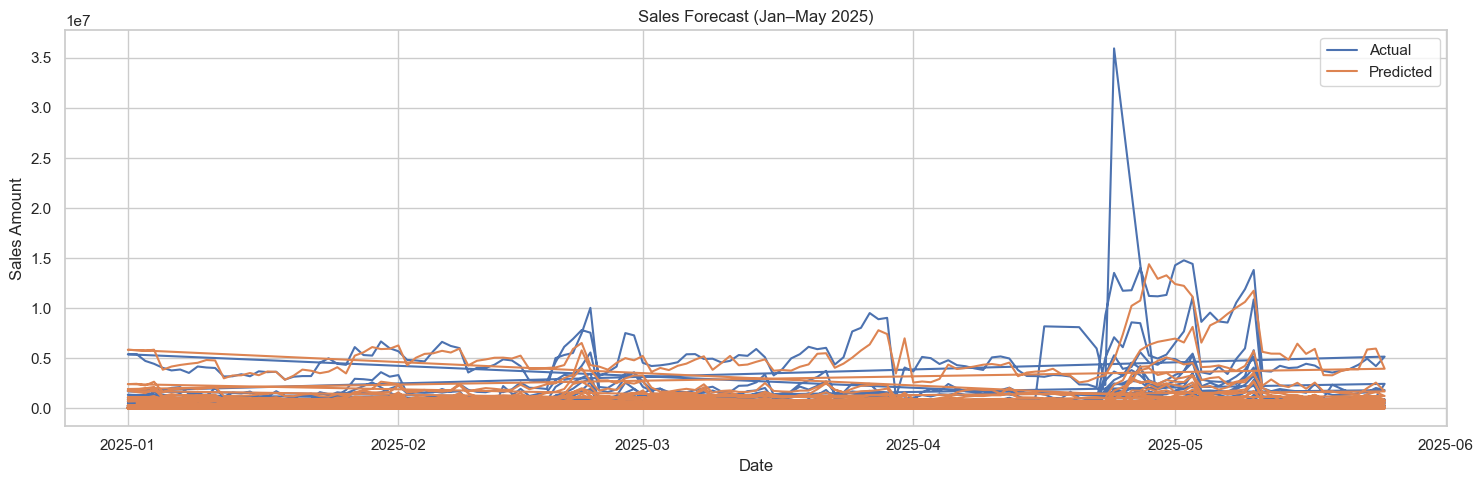

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,5))
plt.plot(test_result['CAL_DATE'], y_test_or.values, label='Actual')
plt.plot(test_result['CAL_DATE'], y_pred, label='Predicted')
plt.legend()
plt.title("Sales Forecast (Jan–May 2025)")
plt.xlabel("Date")
plt.ylabel("Sales Amount")
plt.tight_layout()
plt.show()


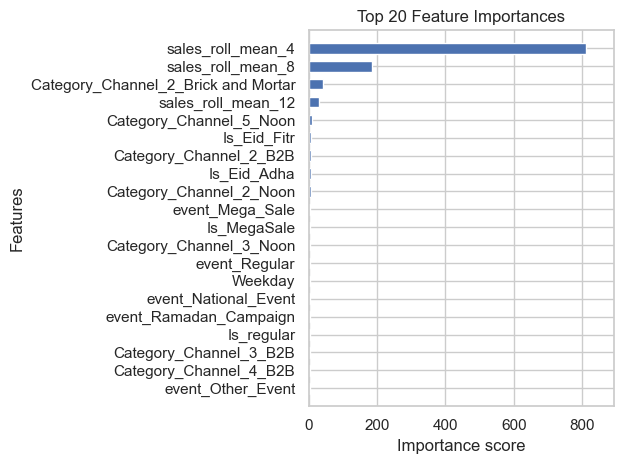

In [14]:
import matplotlib.pyplot as plt
import xgboost as xgb

# Plot feature importance
xgb.plot_importance(model, 
                    max_num_features=20,  # top 20
                    importance_type='gain',  # use 'weight' or 'gain'
                    height=0.6,
                    title='Top 20 Feature Importances',
                    show_values=False)
plt.tight_layout()
plt.show()

In [15]:
X_train.dtypes[X_train.dtypes == 'object']


Series([], dtype: object)

In [16]:
bool_cols = X_train.select_dtypes(include='bool').columns
X_train[bool_cols] = X_train[bool_cols].astype(int)


In [17]:
obj_cols = X_train.select_dtypes(include='object').columns
print("Object columns:", obj_cols.tolist())


Object columns: []


100%|===================| 35683/35752 [03:37<00:00]        

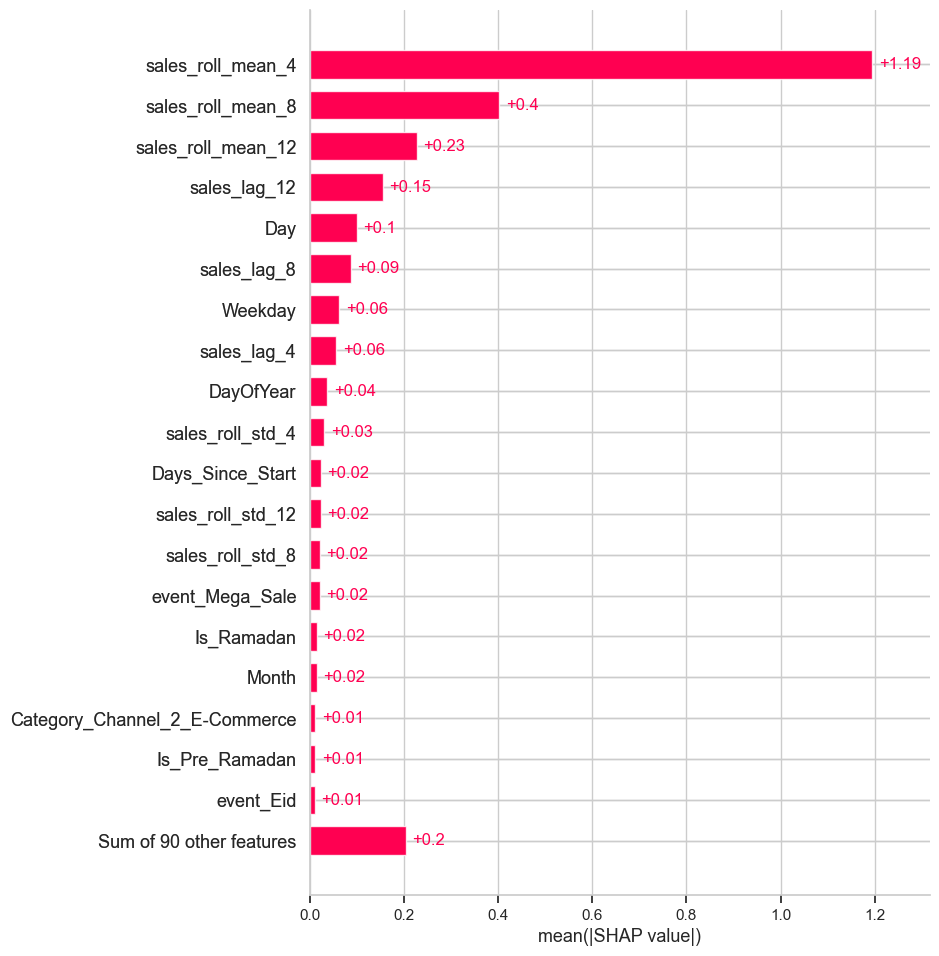

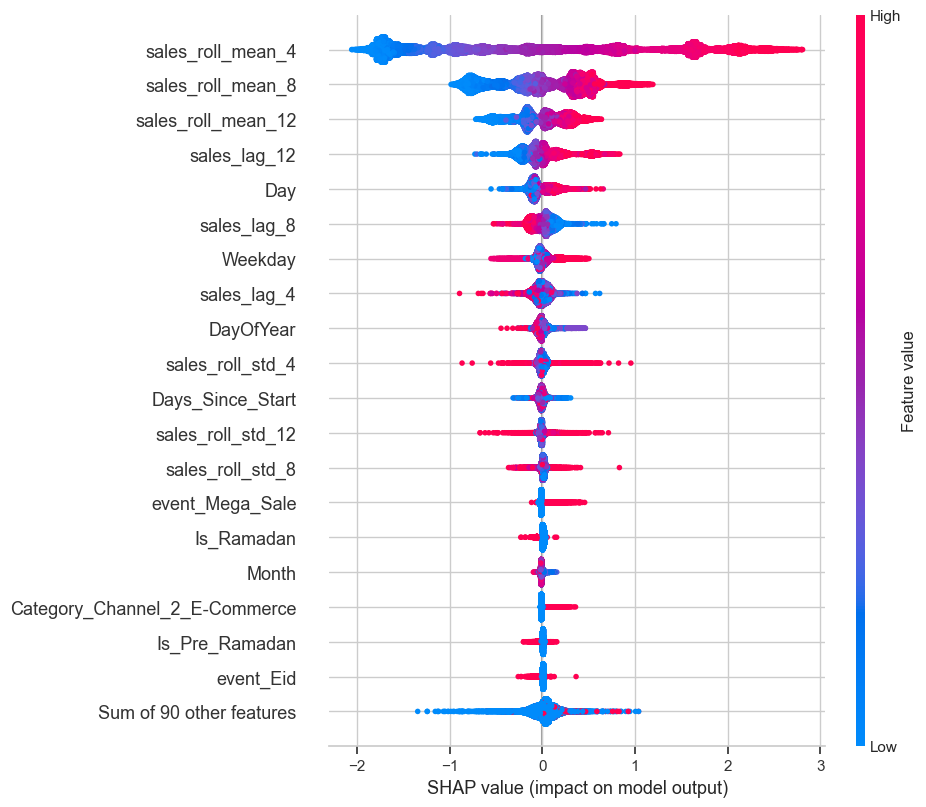

In [18]:
import shap

explainer = shap.Explainer(model, X_train)
shap_values = explainer(X_train)

shap.plots.bar(shap_values, max_display=20)
shap.plots.beeswarm(shap_values, max_display=20)

In [19]:
X_train = pd.get_dummies(X_train, columns=obj_cols)

import shap
explainer = shap.Explainer(model, X_train)
shap_values = explainer(X_train)

shap.plots.bar(shap_values, max_display=20)
shap.plots.beeswarm(shap_values, max_display=20)

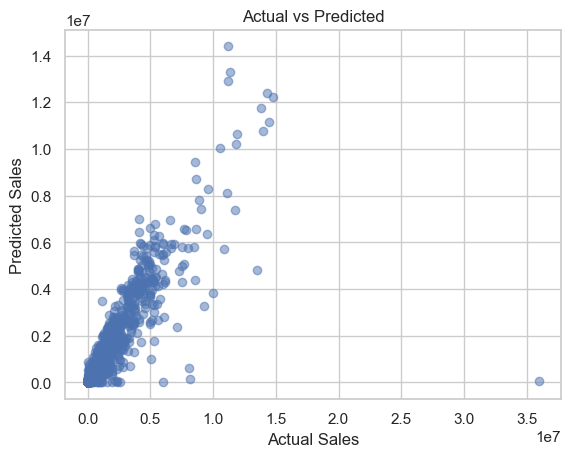

In [20]:
import matplotlib.pyplot as plt

plt.scatter(y_test_or, y_pred, alpha=0.5)
plt.xlabel('Actual Sales')
plt.ylabel('Predicted Sales')
plt.title('Actual vs Predicted')
plt.show()


In [21]:
def smape(y_test_or, y_pred_log):
    return 100/len(y_test_or) * np.sum(2 * np.abs(y_pred - y_test_or) / (np.abs(y_test_or) + np.abs(y_pred)))

print("✅ SMAPE:", smape(y_test_or, y_pred))


✅ SMAPE: 33.80861706759446


In [22]:
def correlation(y_true, y_pred):
    return np.corrcoef(y_true, y_pred)[0, 1]

print("✅ CORRELATION:", correlation(y_test_or, y_pred))


✅ CORRELATION: 0.8697916858853704


In [23]:
# ✅ Step 1: Identify the one-hot encoded columns
category_channel_cols = [col for col in test_result.columns if col.startswith('Category_Channel_')]

# ✅ Step 2: Reconstruct the original Category_Channel column
test_result['Category_Channel'] = test_result[category_channel_cols].idxmax(axis=1).str.replace('Category_Channel_', '')

# ✅ Optional: Drop the one-hot encoded columns
test_result.drop(columns=category_channel_cols, inplace=True)


In [24]:
test_result[['LOG_SALES']]
test_result['SALES_AMOUNT'] = np.expm1(df['LOG_SALES'])

In [25]:
# ✅ Define the columns to keep
keep_columns = ['Category_Channel', 'CAL_DATE', 'HIJRI_DATE', 'Main Event', 'SALES_AMOUNT', 'PREDICTED_SALES']

# ✅ Keep only the specified columns
test_result = test_result[keep_columns]

In [26]:
test_result.rename(columns={
    'Category_Channel': 'unique_id',
    'CAL_DATE': 'ds'
}, inplace=True)


In [27]:
test_result.head()

unique_id         ds  HIJRI_DATE   Main Event  SALES_AMOUNT  \
848  101_Brick and Mortar 2025-01-01  1446-07-01  End Of Year       3388.52   
849  101_Brick and Mortar 2025-01-02  1446-07-02  End Of Year       3112.15   
850  101_Brick and Mortar 2025-01-03  1446-07-03  End Of Year       3728.18   
851  101_Brick and Mortar 2025-01-04  1446-07-04  End Of Year       2816.12   
852  101_Brick and Mortar 2025-01-05  1446-07-05  End Of Year       2705.04   

     PREDICTED_SALES  
848      3037.288574  
849      3058.129150  
850      3127.092529  
851      3614.545166  
852      2586.943359

In [28]:
test_result.to_csv("sales_predictions_XGB.csv", index=False)
print("✅ Predictions saved to 'sales_predictions_XGB.csv'")


✅ Predictions saved to 'sales_predictions_XGB.csv'


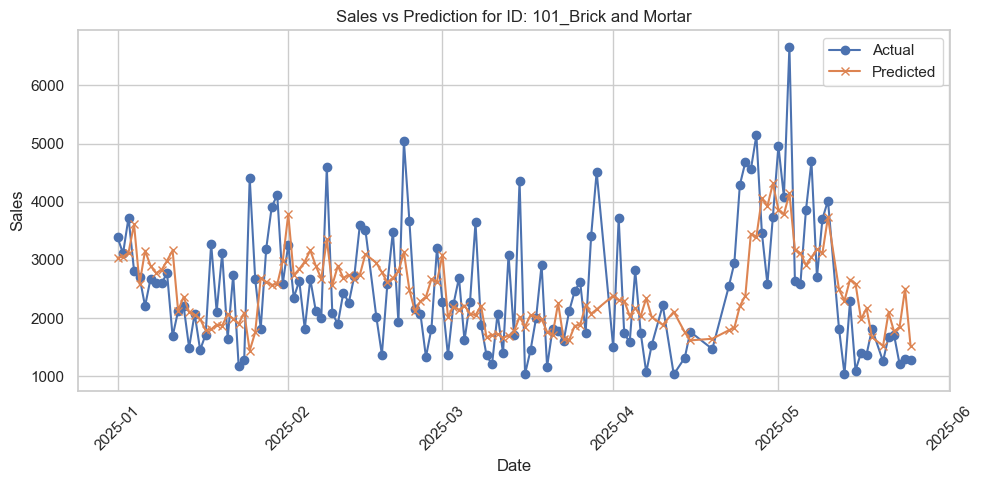

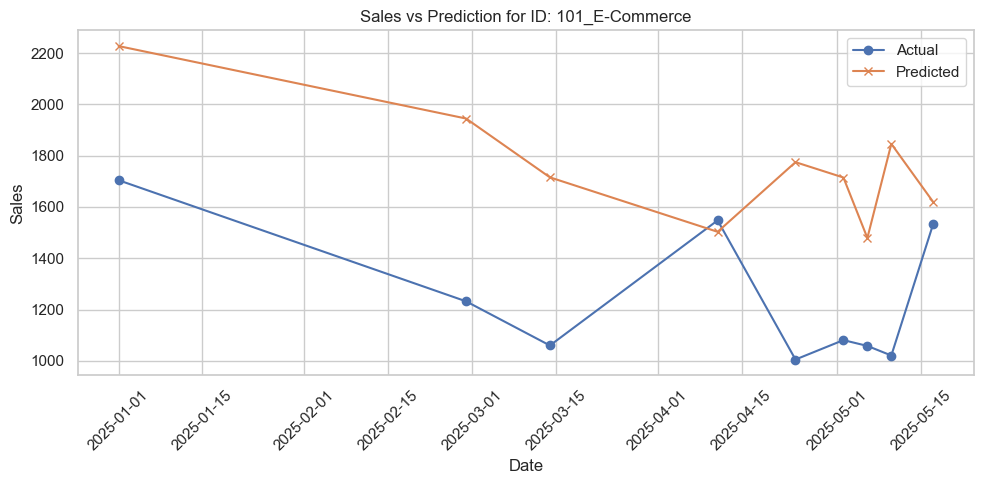

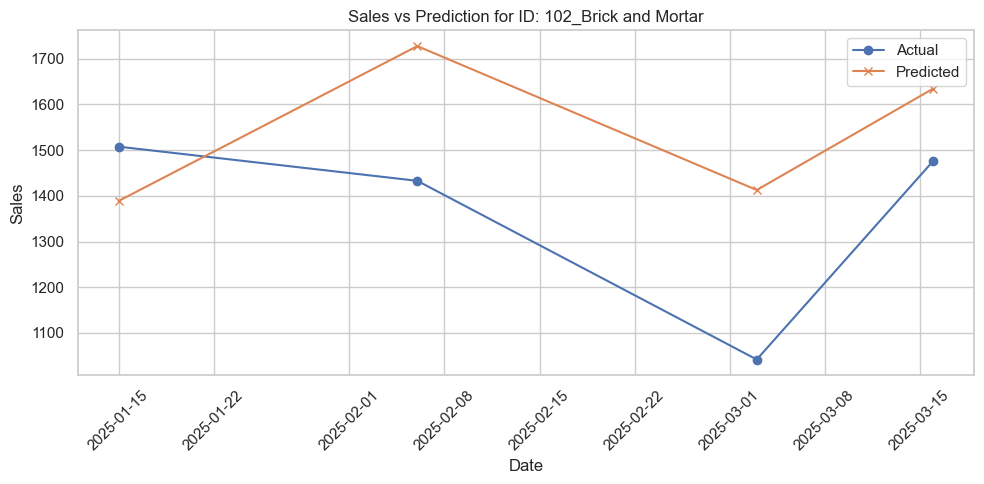

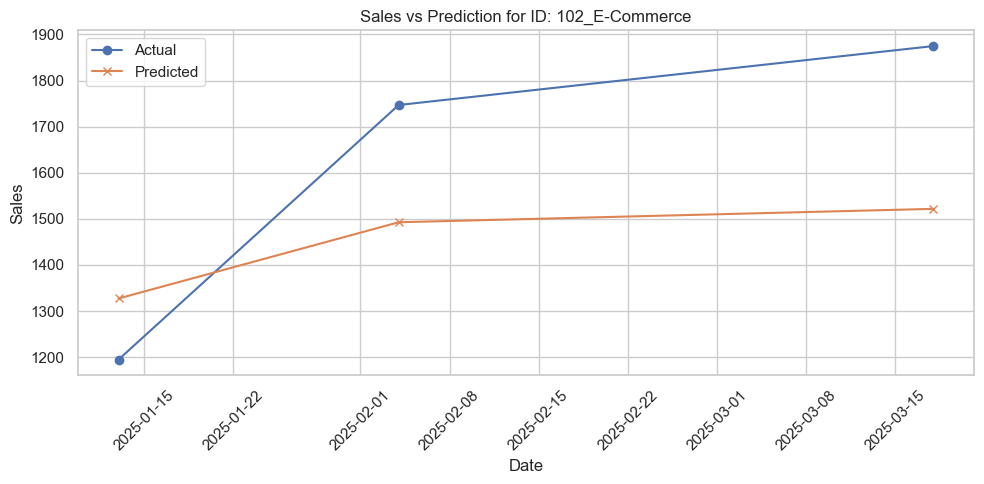

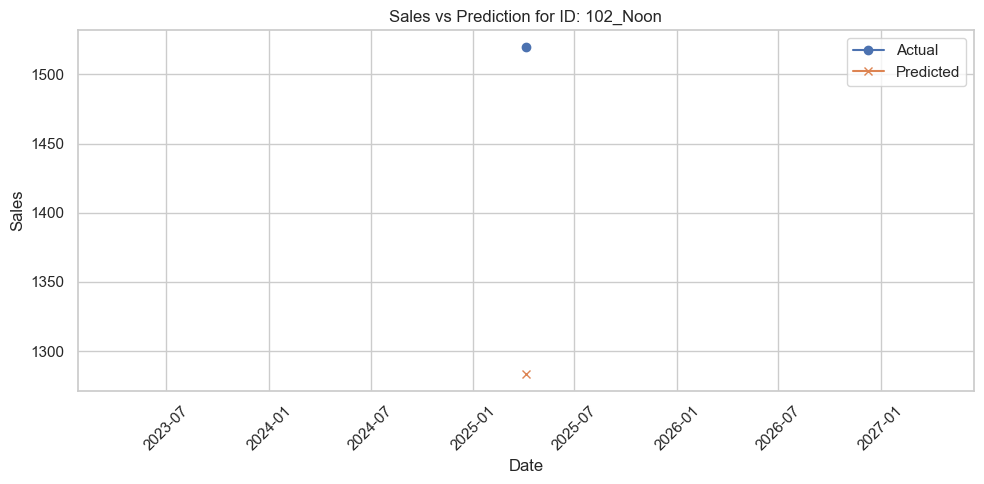

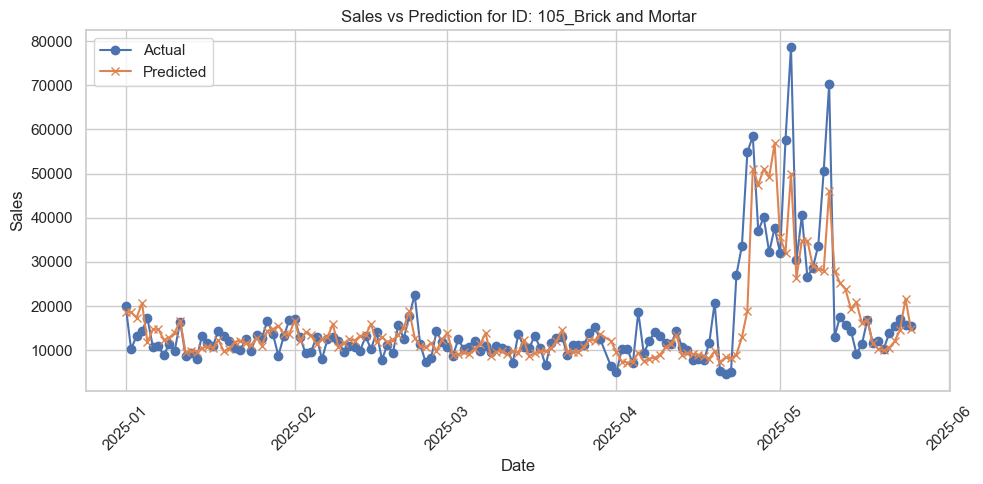

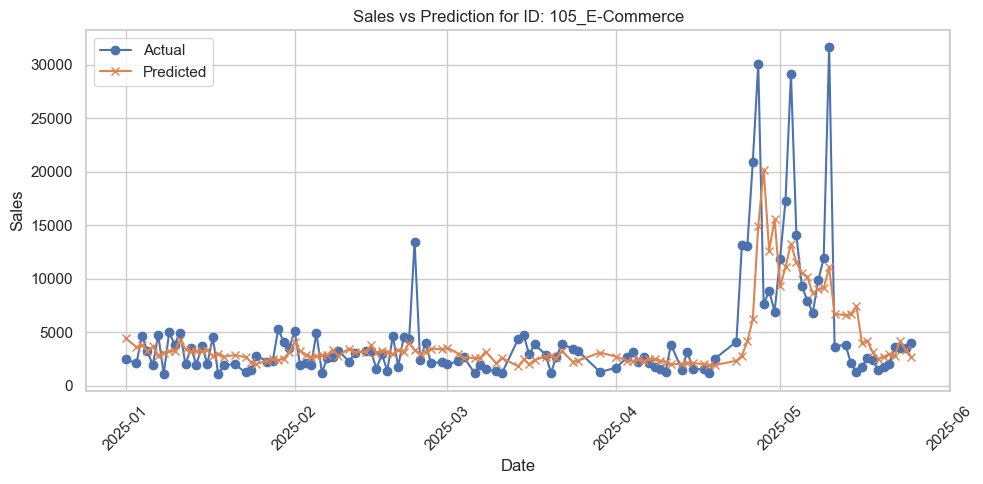

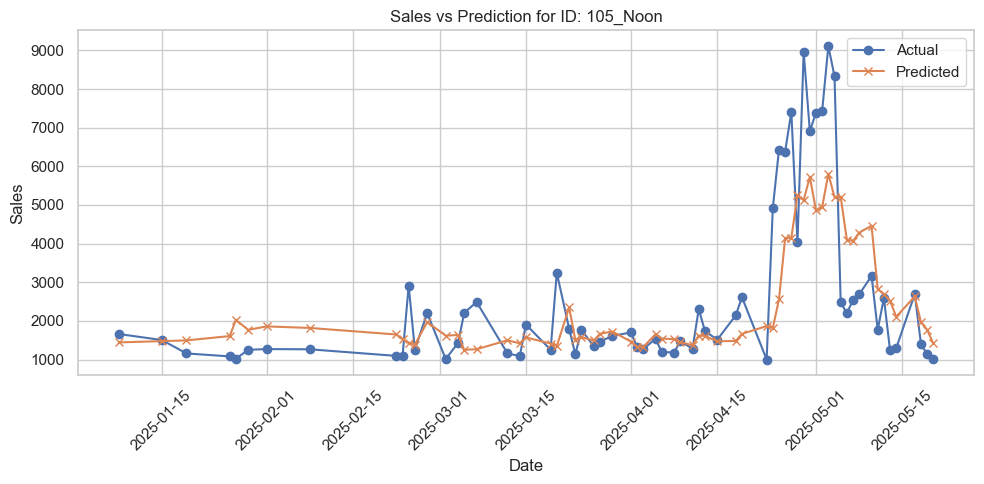

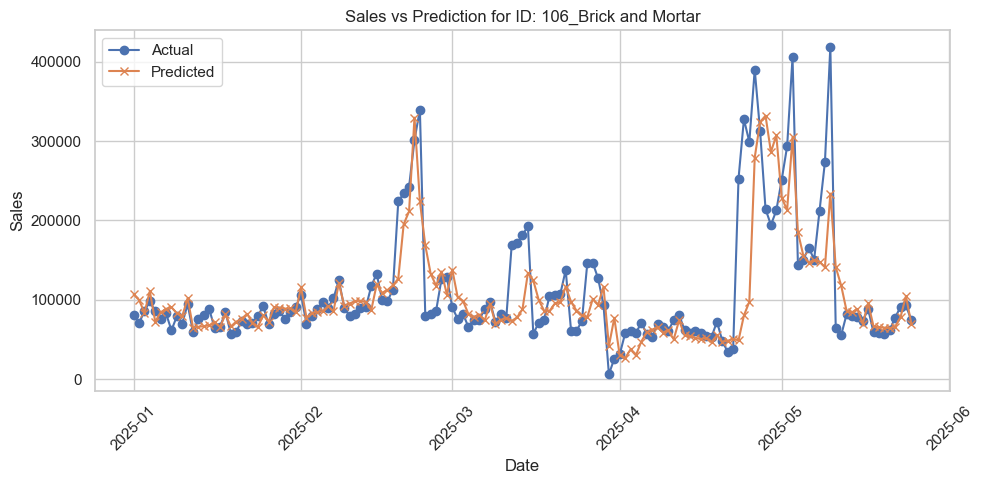

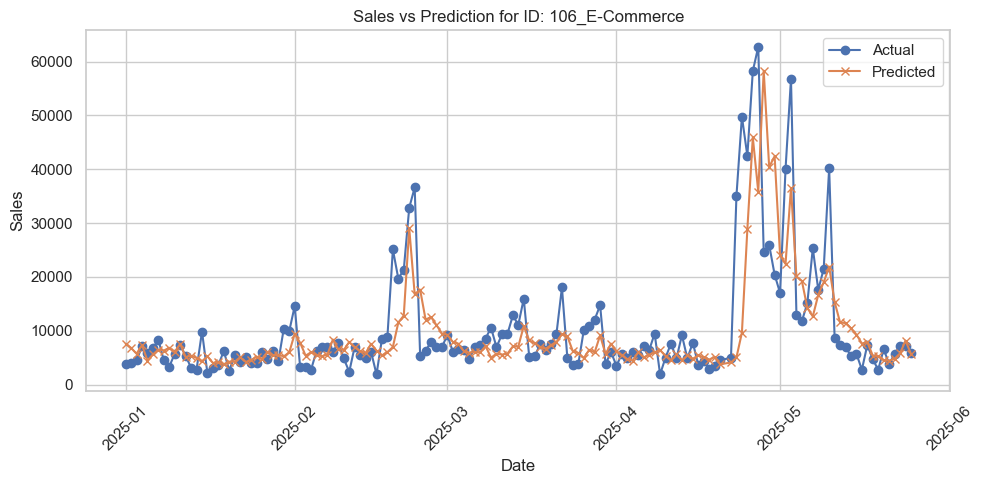

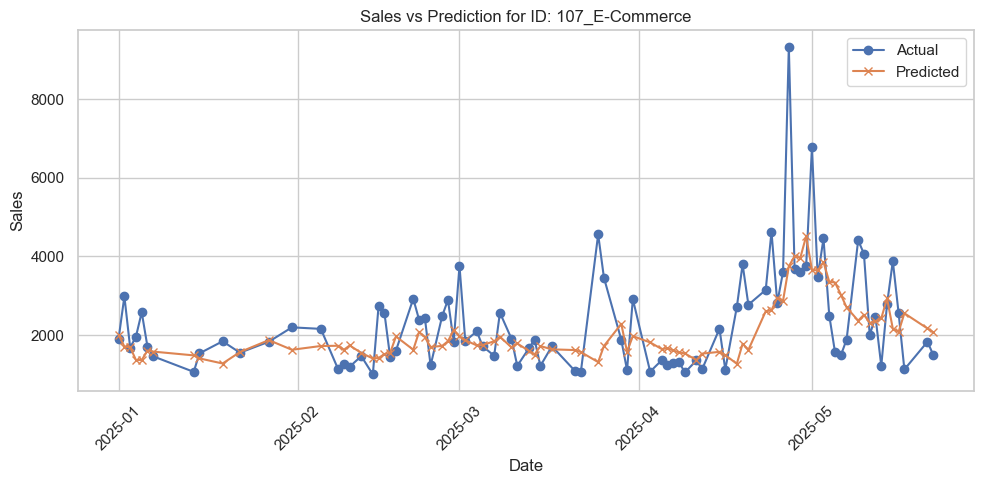

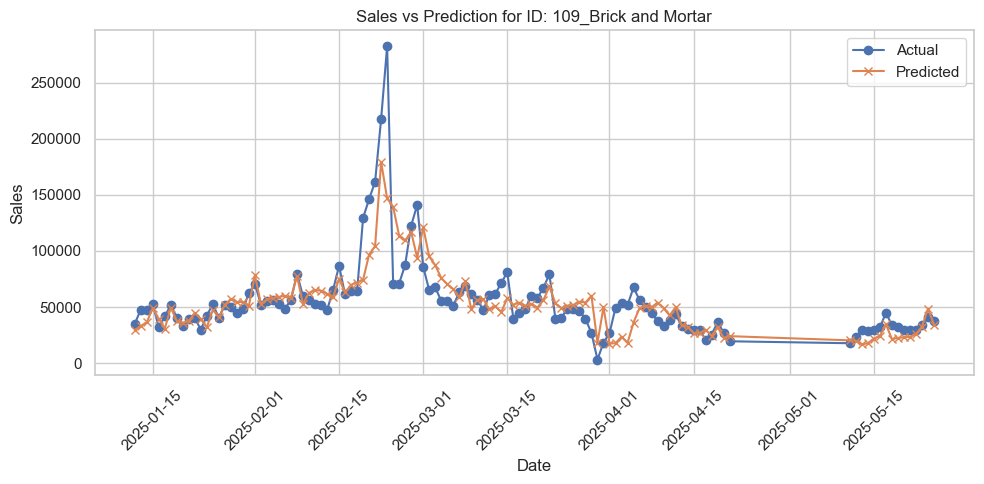

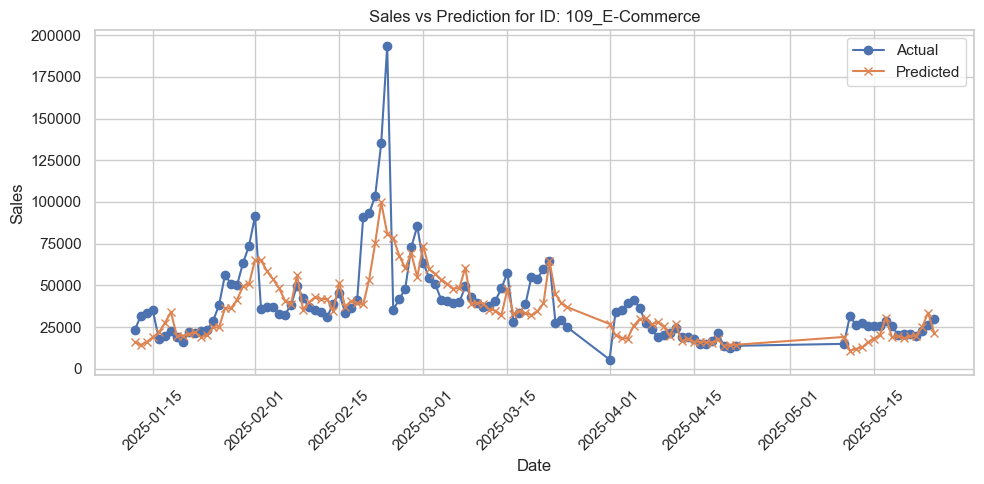

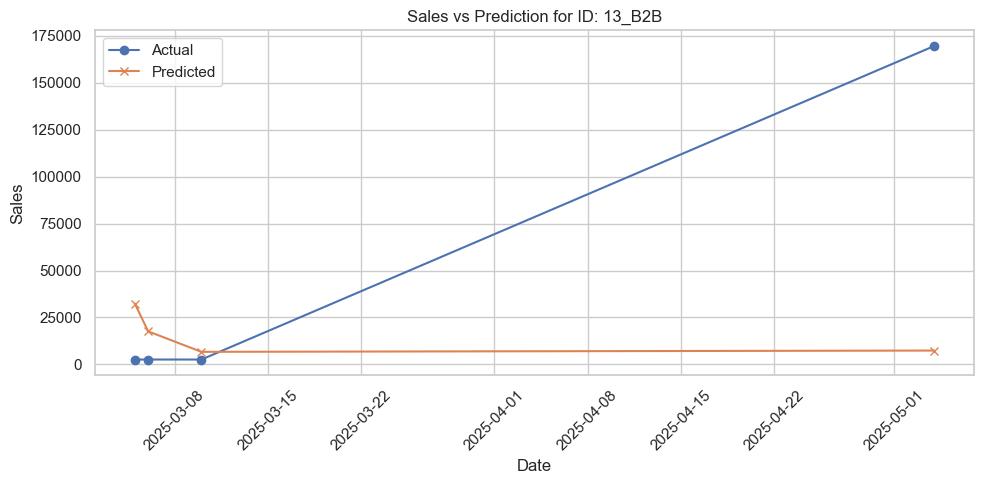

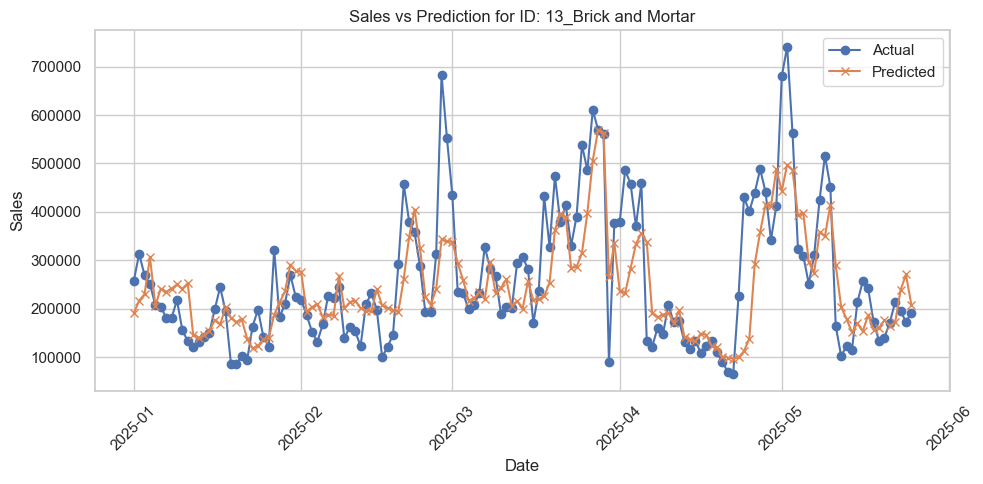

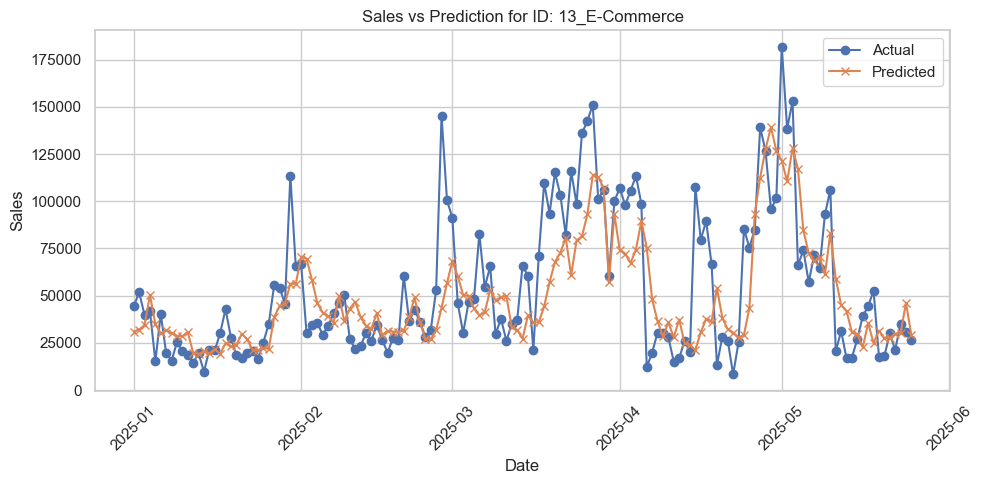

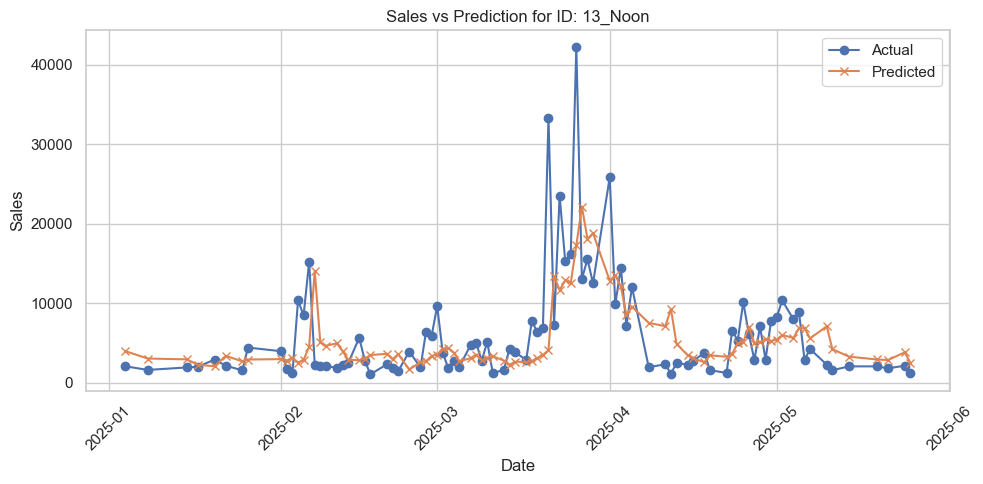

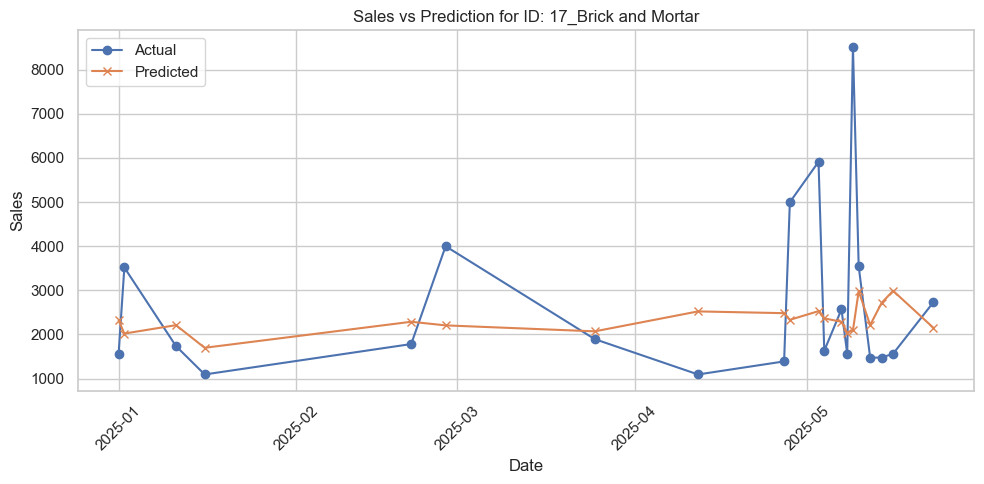

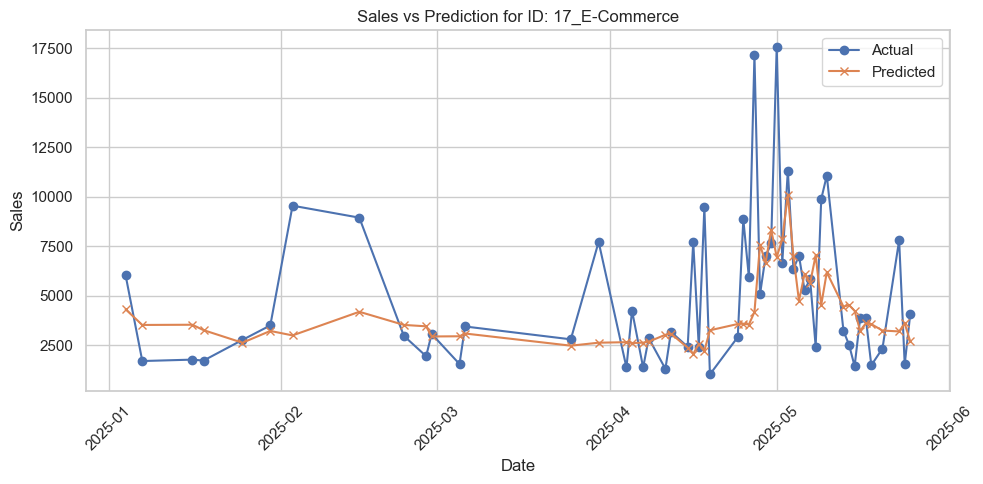

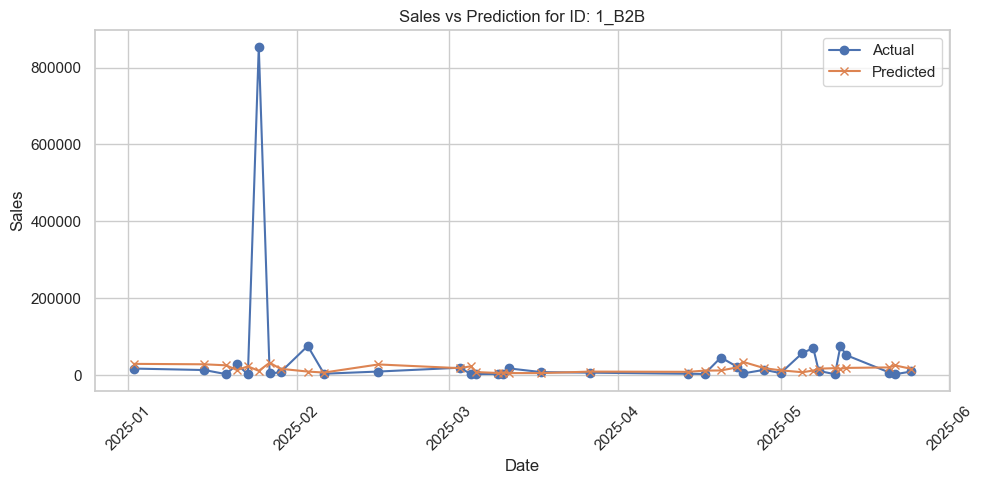

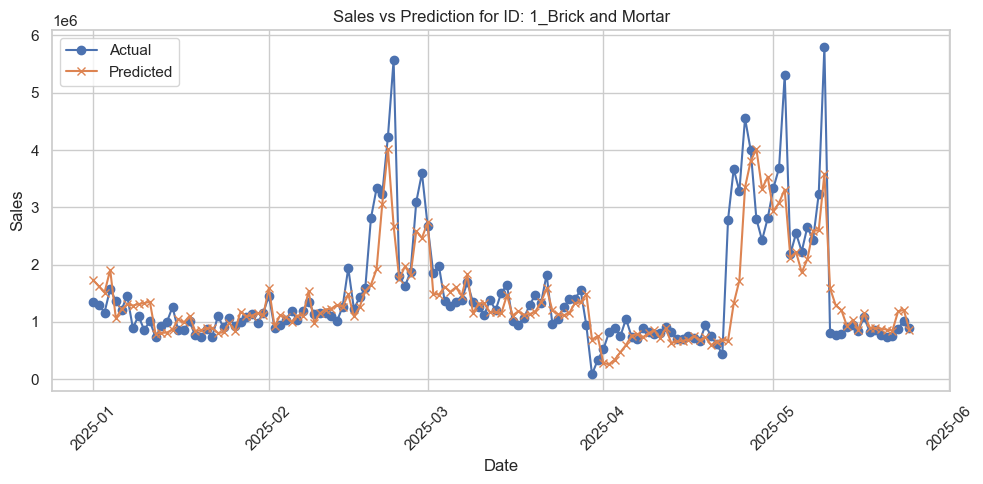

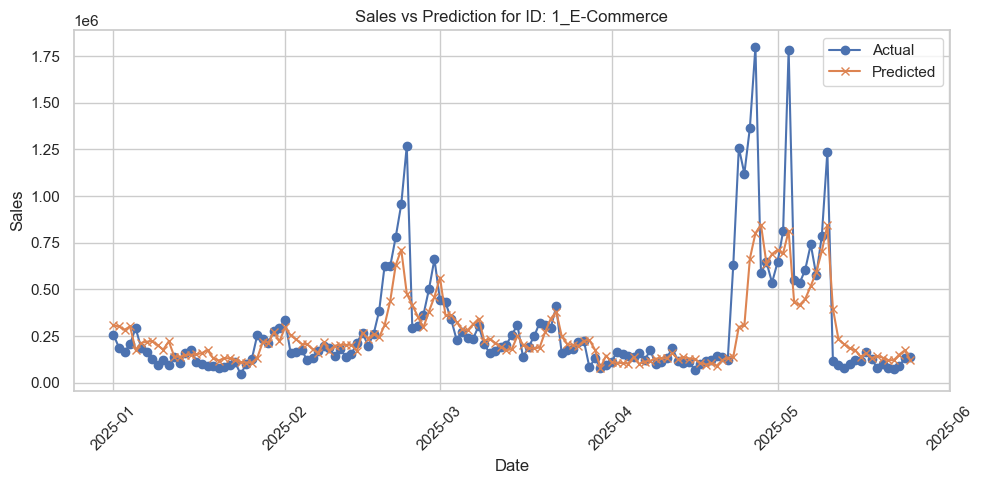

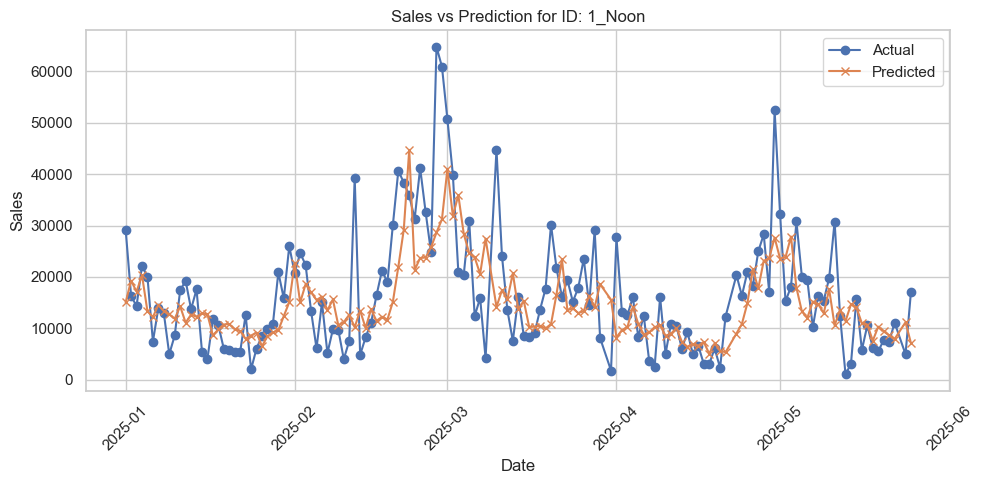

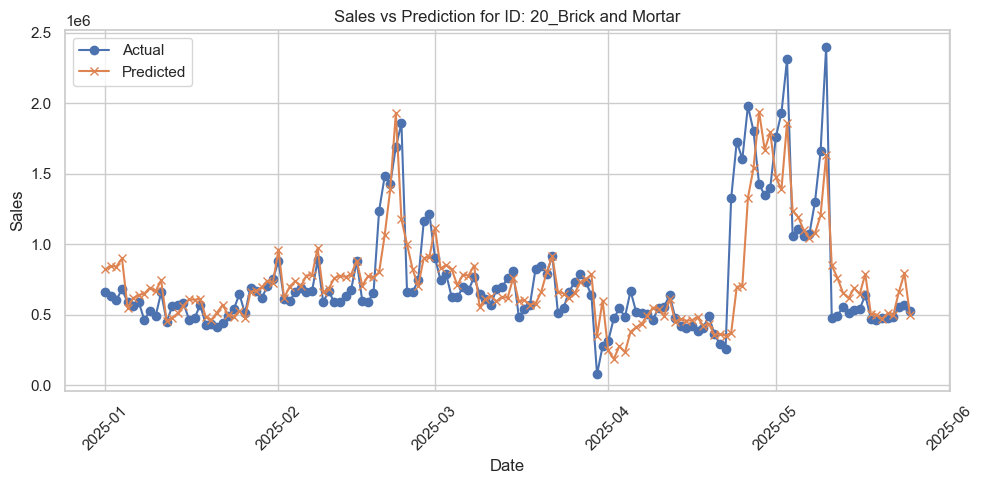

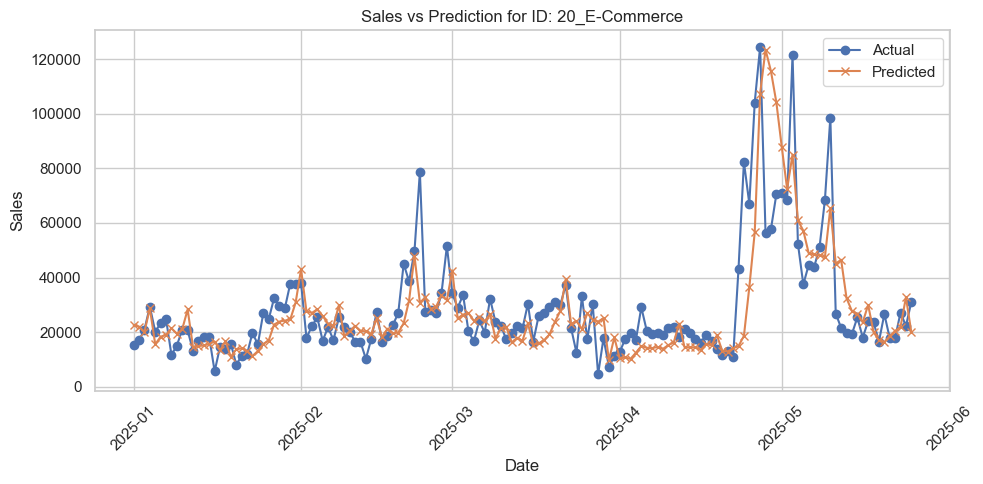

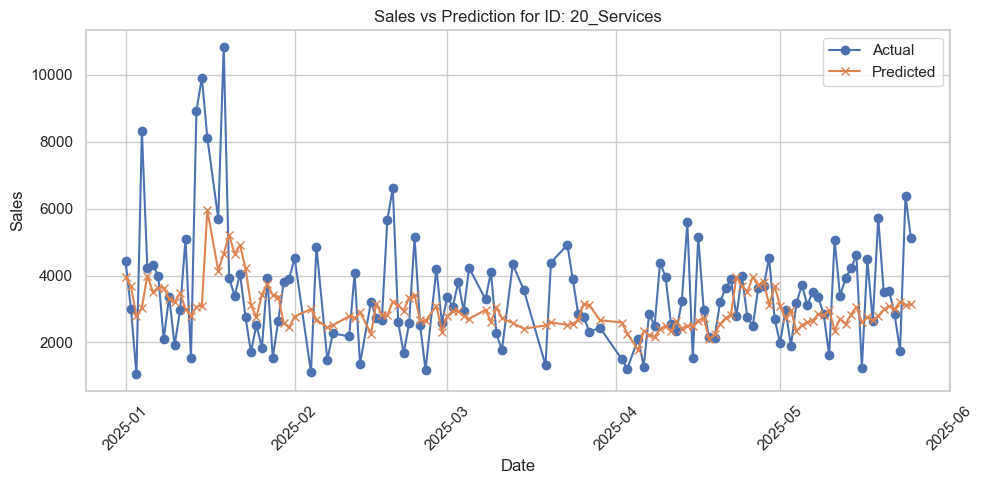

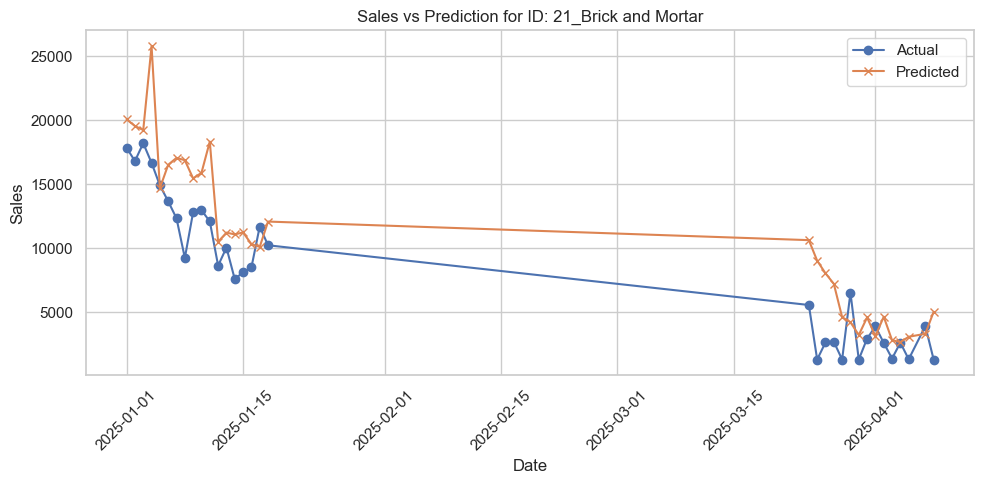

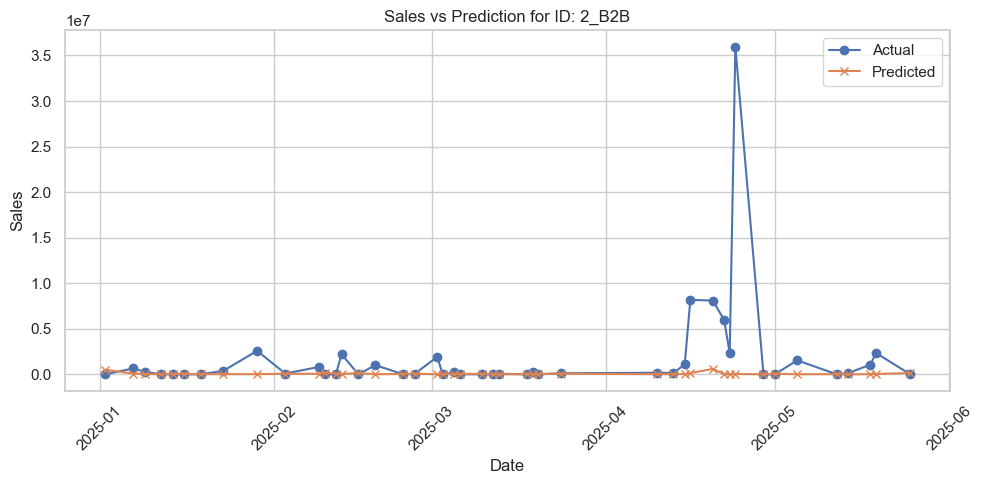

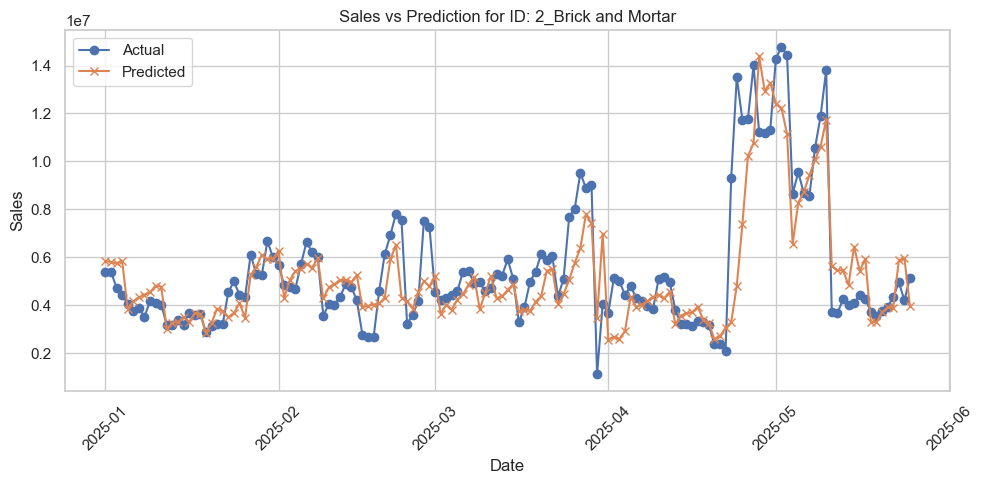

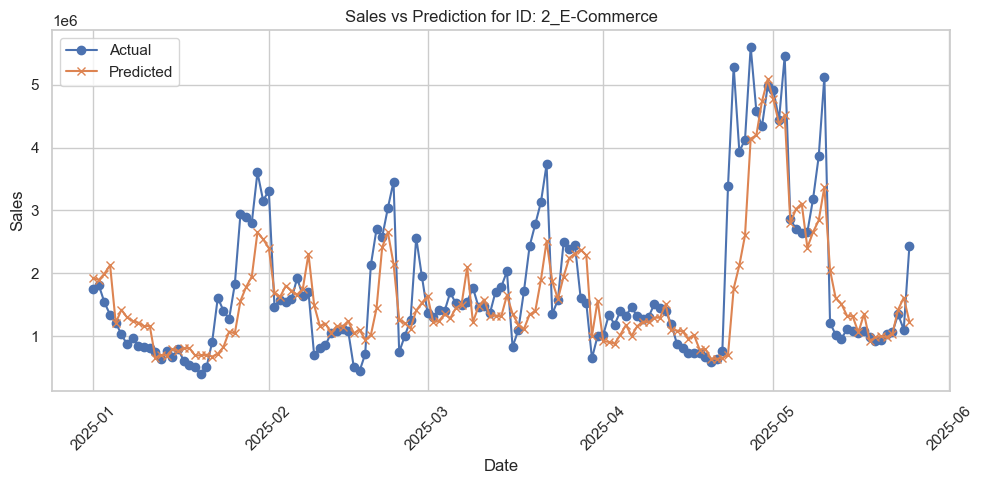

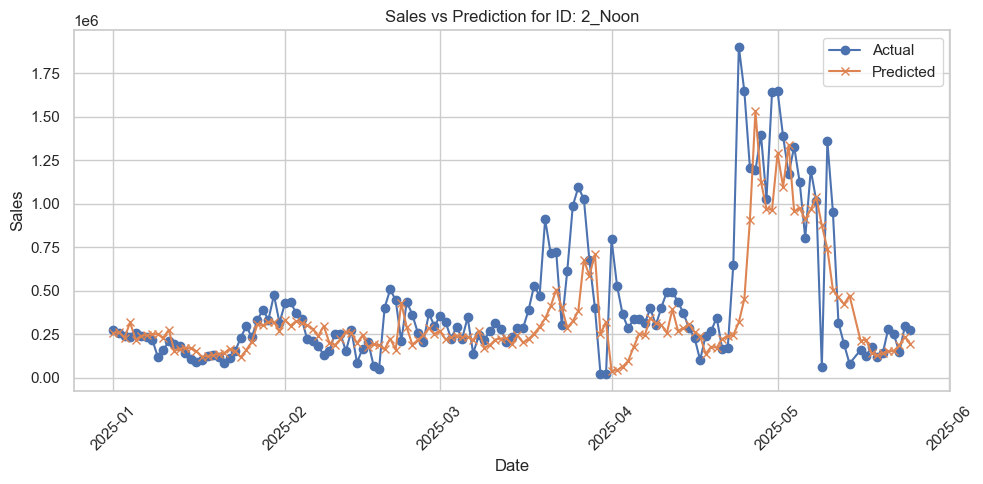

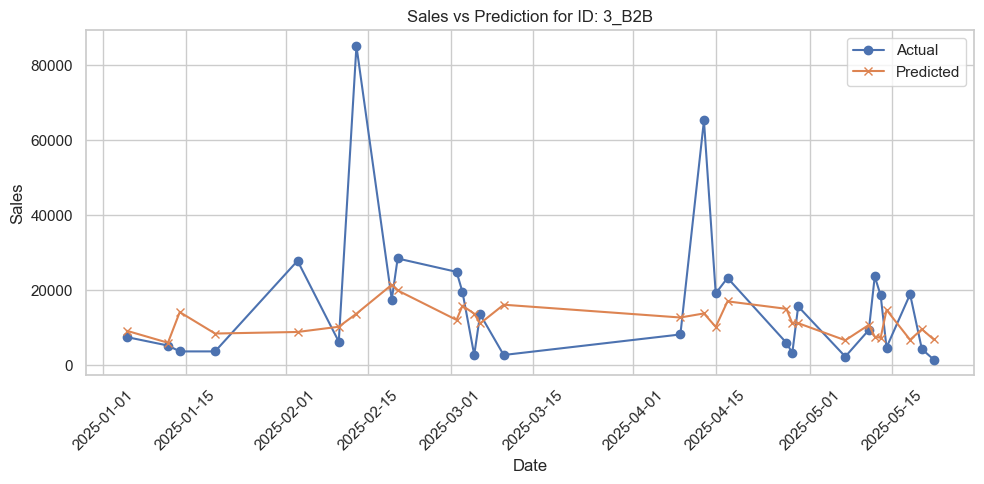

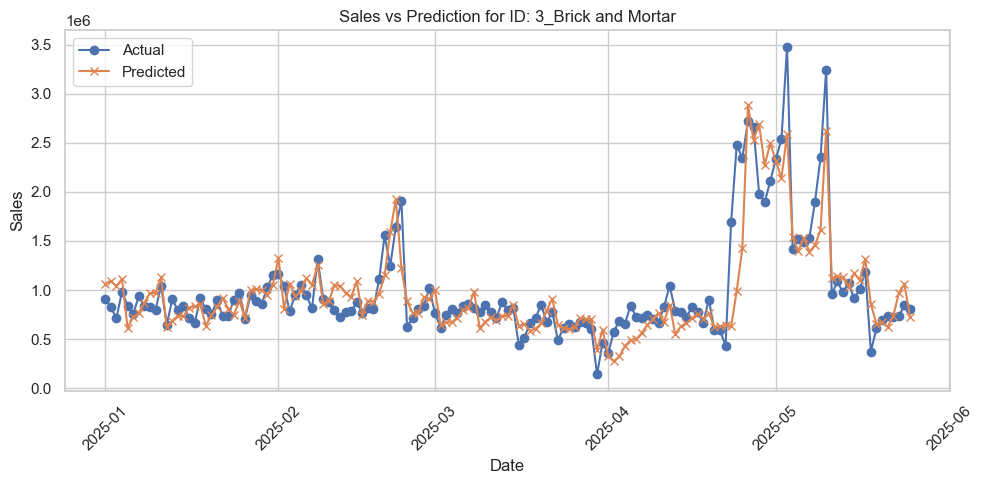

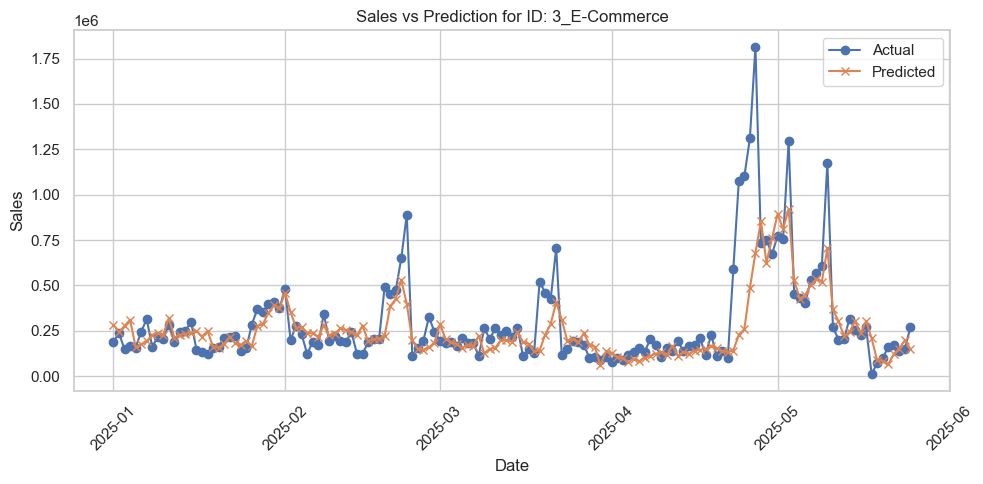

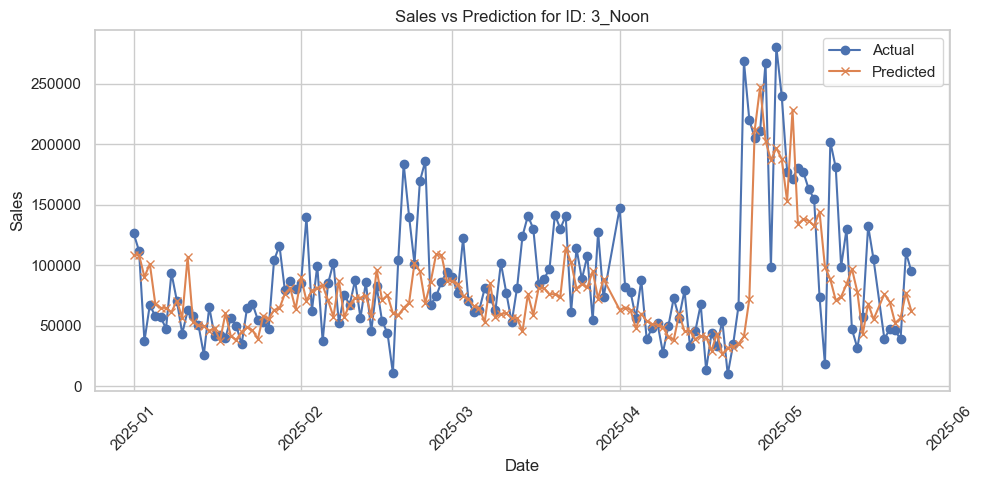

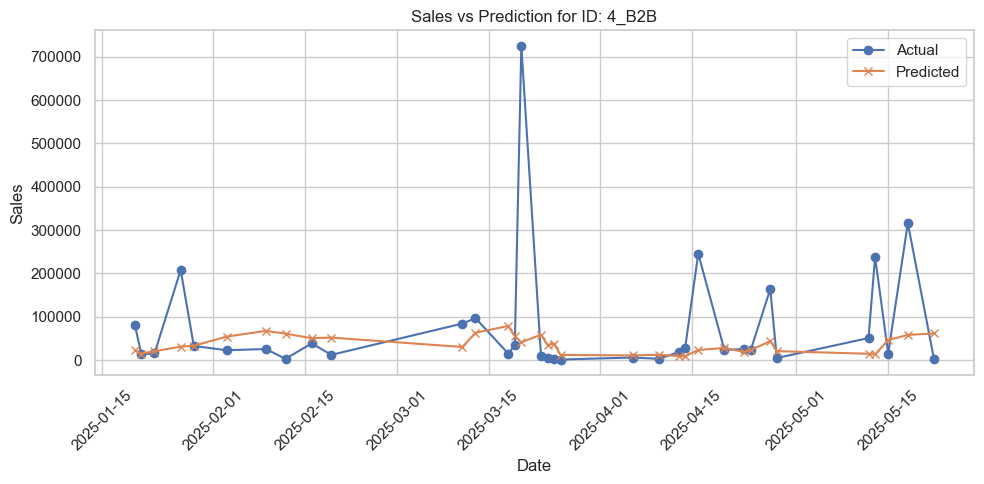

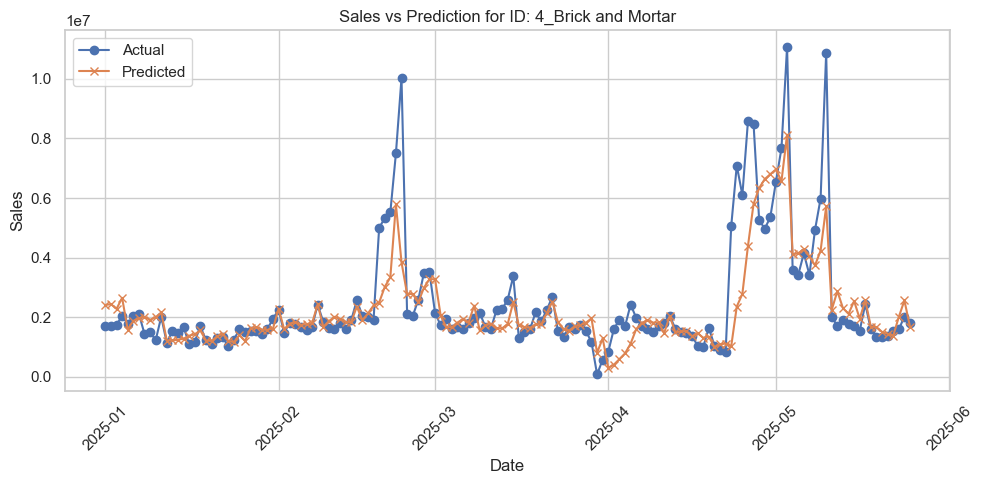

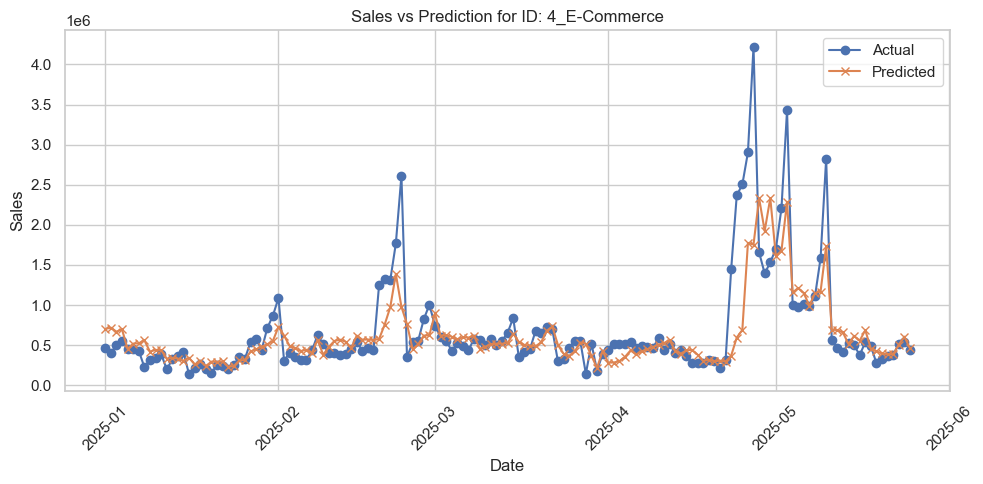

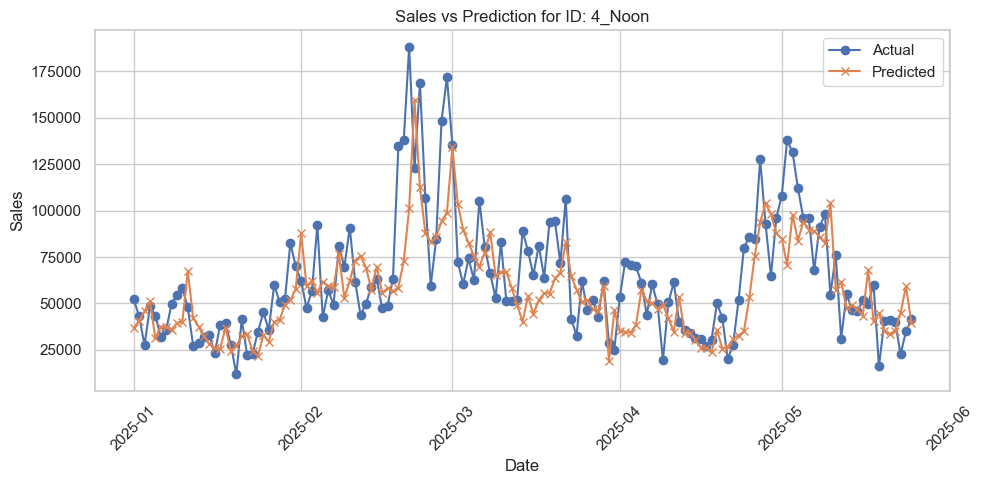

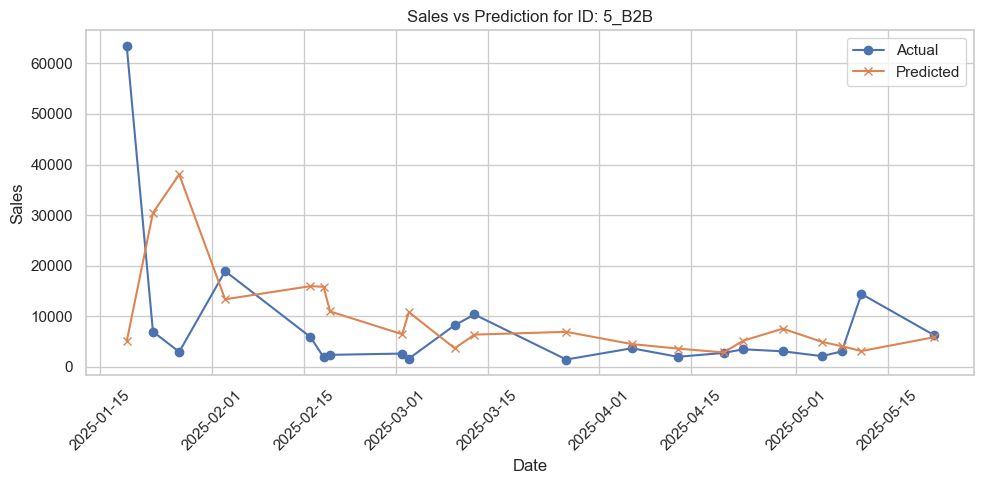

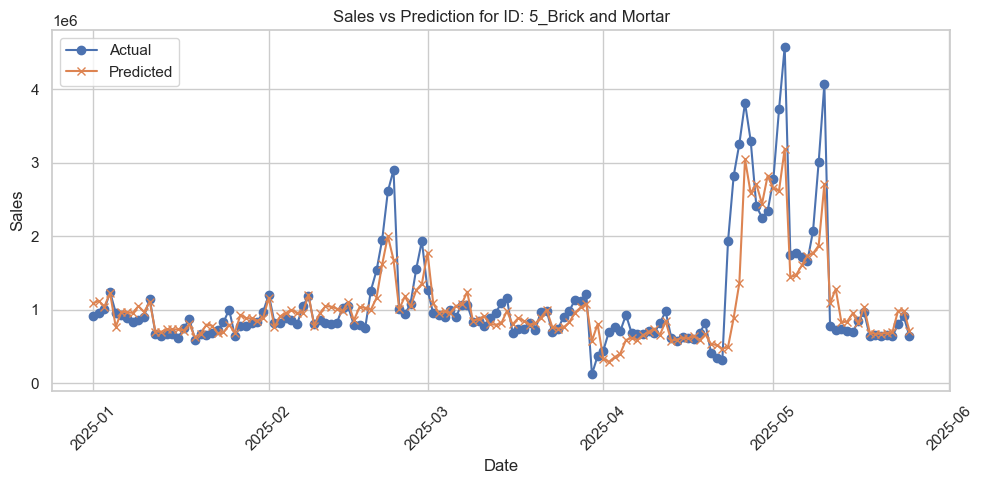

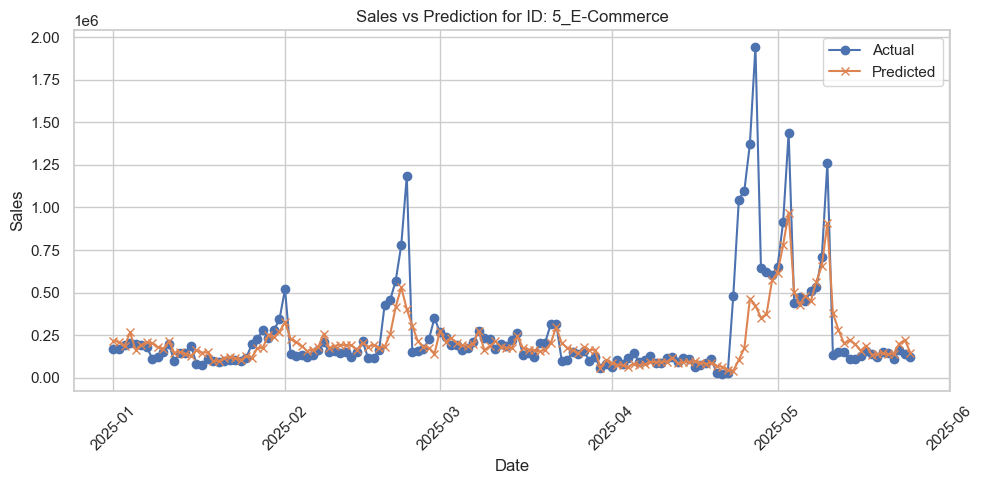

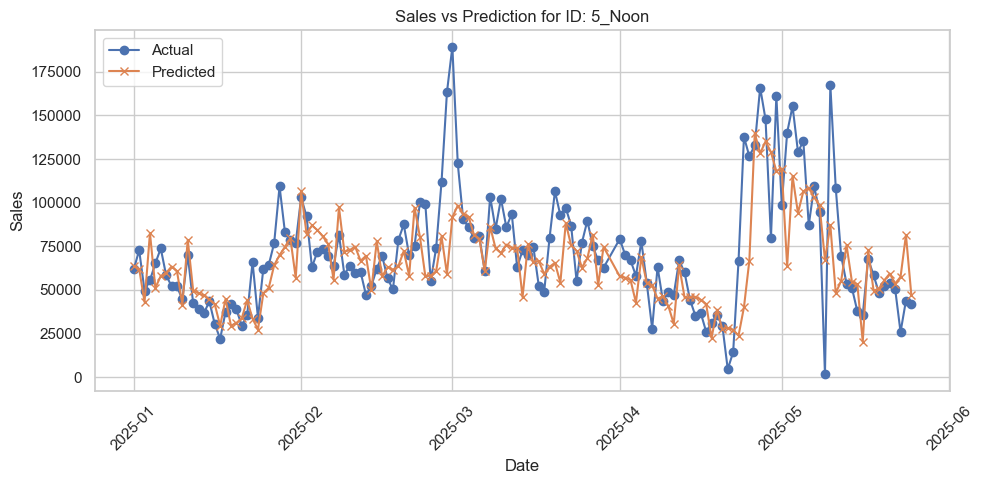

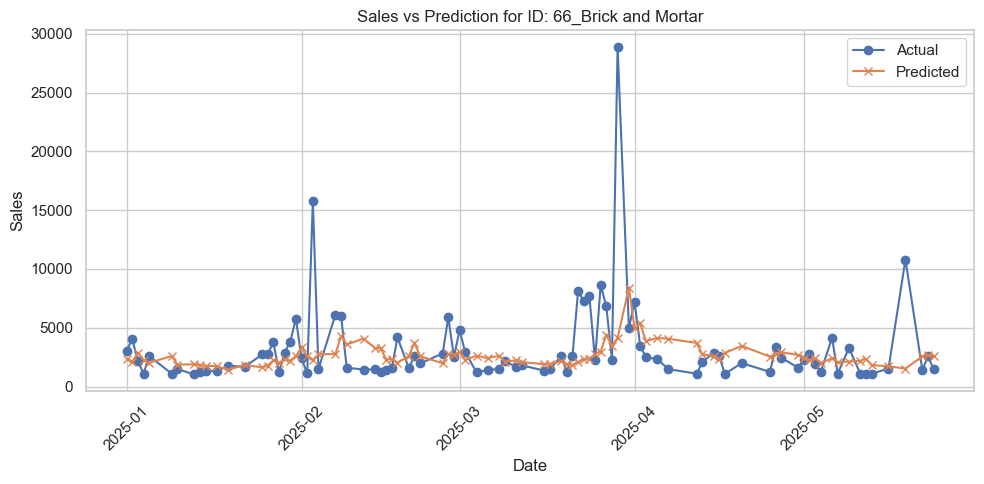

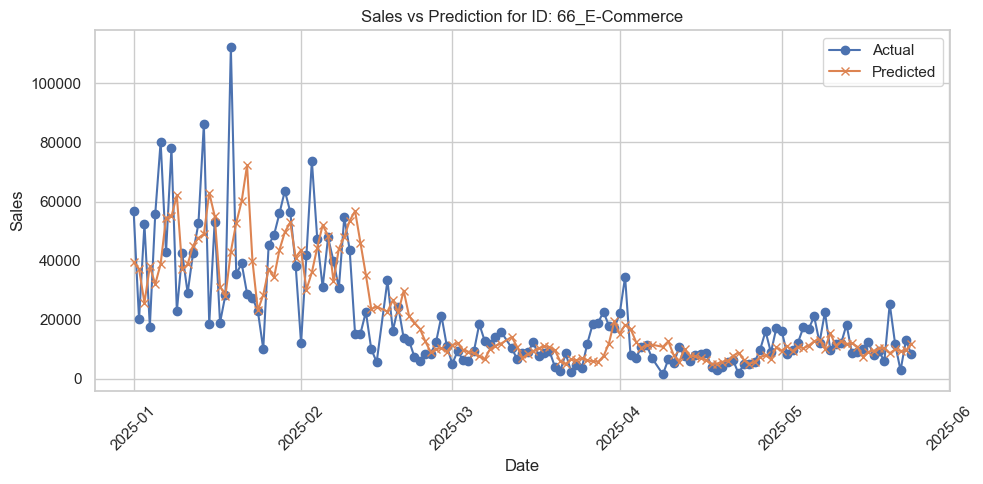

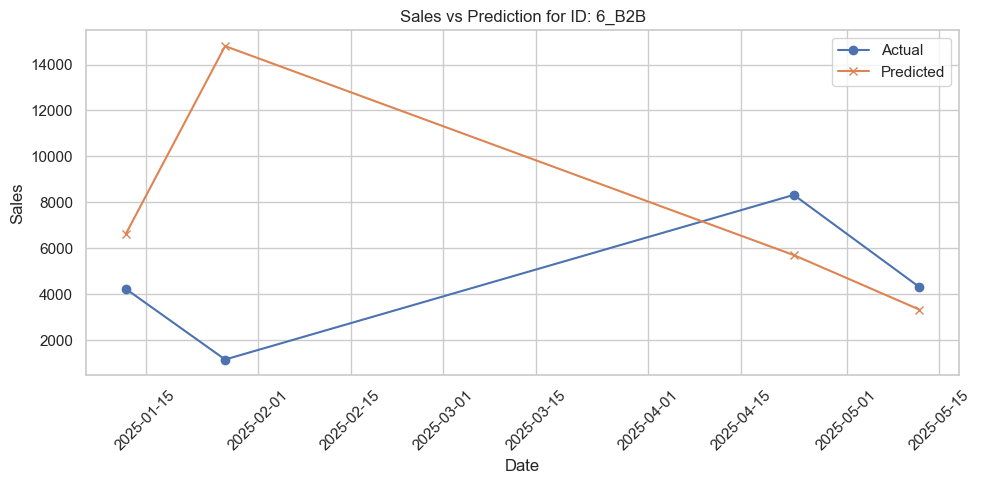

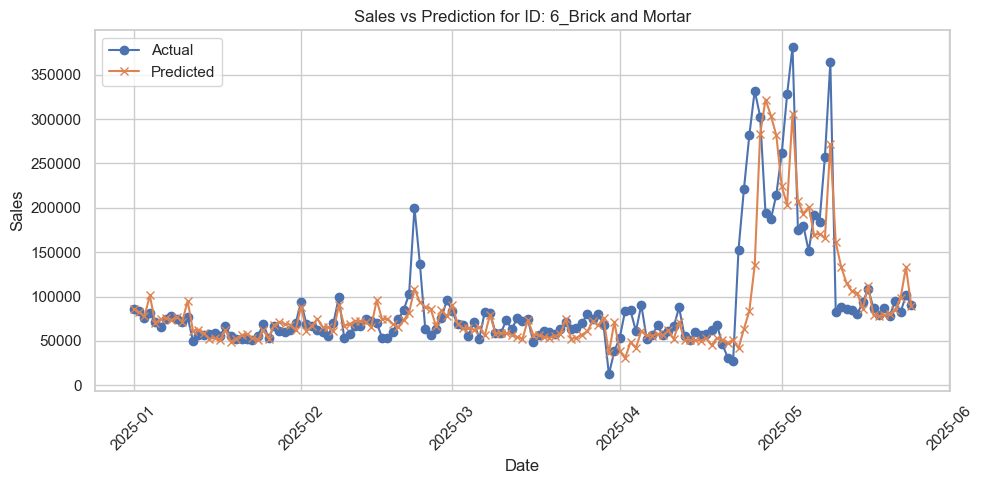

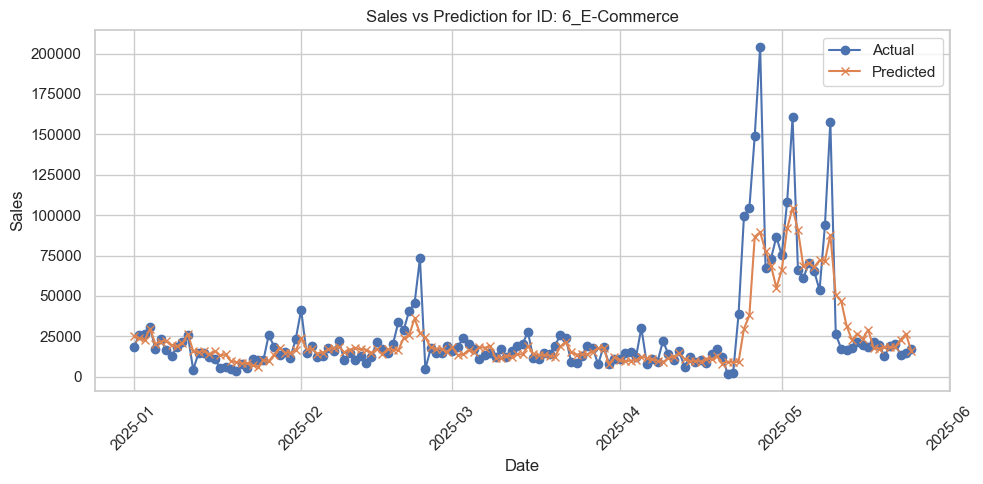

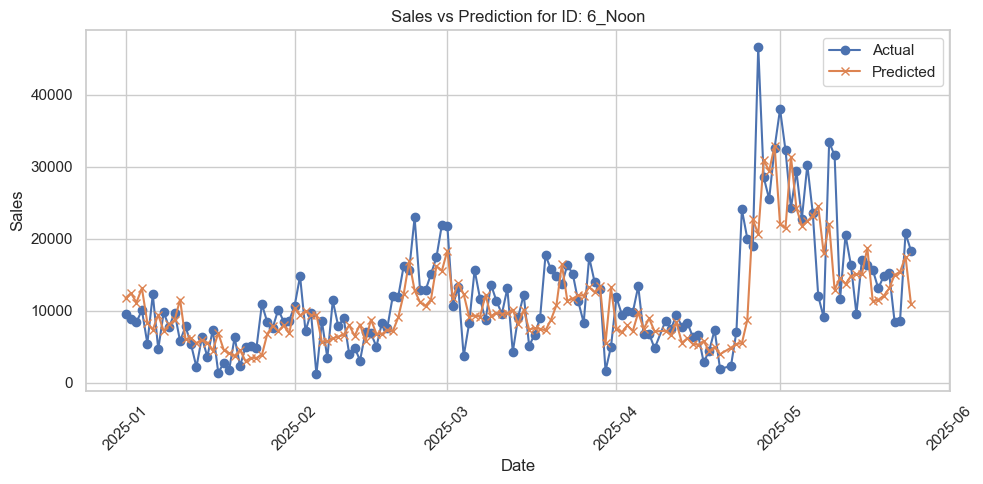

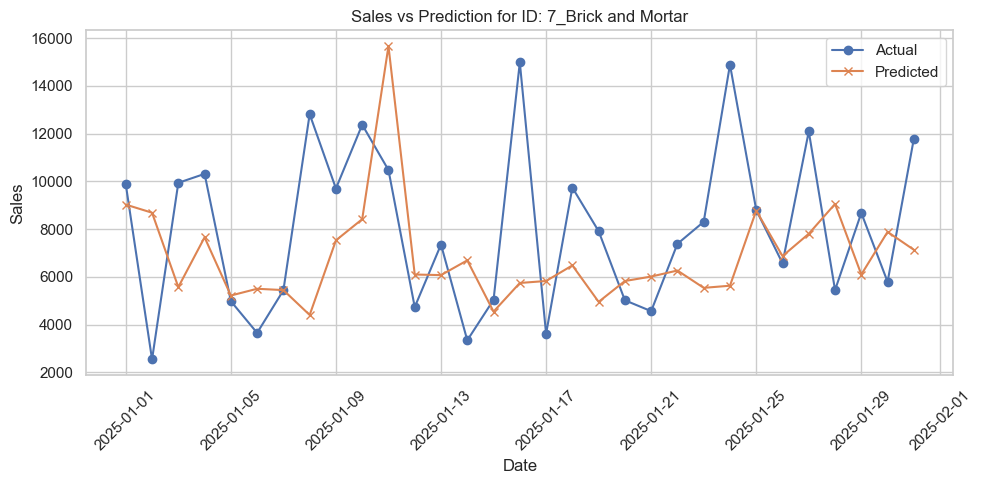

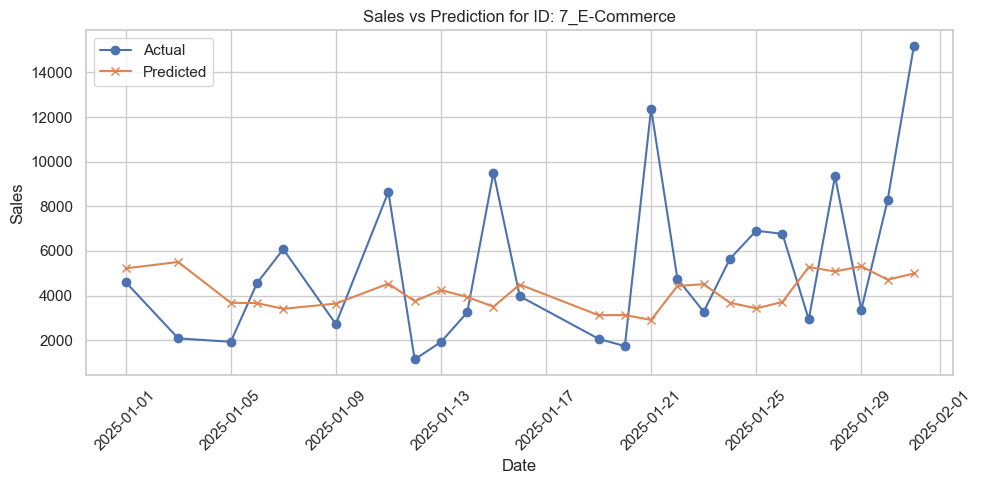

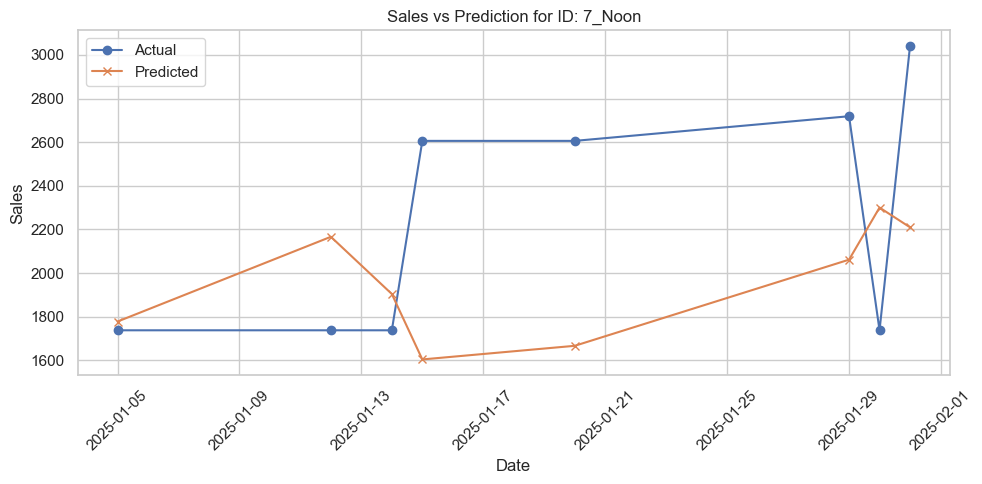

In [29]:
import matplotlib.pyplot as plt

# Get unique IDs
ids = test_result['unique_id'].unique()

# Plot one figure per unique_id
for uid in ids:
    df_uid = test_result[test_result['unique_id'] == uid]
    
    plt.figure(figsize=(10, 5))
    plt.plot(df_uid['ds'], df_uid['SALES_AMOUNT'], label='Actual', marker='o')
    plt.plot(df_uid['ds'], df_uid['PREDICTED_SALES'], label='Predicted', marker='x')
    plt.title(f"Sales vs Prediction for ID: {uid}")
    plt.xlabel("Date")
    plt.ylabel("Sales")
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()